In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ast
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
import tensorflow as tf
from tensorflow.keras import layers, models
import wfdb

### Load Data

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

In [4]:
X[0] # First example

array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [5]:
y = Y['diagnostic_superclass'].to_numpy()
classes, counts = np.unique(y, return_counts=True)
classes, counts # Don't end up with same counts each time - fix?

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([4898, 1860, 2532, 9510, 2999]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

### Correct Data Imbalance

In [7]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print(train_classes, train_counts)
smallest_class_count = min(train_counts)
print(smallest_class_count)

['CD' 'HYP' 'MI' 'NORM' 'STTC'] [3885 1503 2055 7584 2412]
1503


In [8]:
def get_class_subset(ekg_class):
    y_train_class_indices = np.where(y_train == ekg_class)[0]
    y_train_class_subset_indices = np.random.choice(
        y_train_class_indices,
        size=smallest_class_count,
        replace=False
    )
    X_train_class_subset = X_train[y_train_class_subset_indices]
    y_train_class_subset = np.array([ekg_class] * smallest_class_count)
    return X_train_class_subset, y_train_class_subset

X_train_cd, y_train_cd = get_class_subset('CD')
X_train_hyp, y_train_hyp = get_class_subset('HYP')
X_train_mi, y_train_mi = get_class_subset('MI')
X_train_norm, y_train_norm = get_class_subset('NORM')
X_train_sttc, y_train_sttc = get_class_subset('STTC')

In [9]:
print(X_train_cd.shape)
print(X_train_hyp.shape)
print(X_train_mi.shape)
print(X_train_norm.shape)
print(X_train_sttc.shape)

(1503, 1000, 12)
(1503, 1000, 12)
(1503, 1000, 12)
(1503, 1000, 12)
(1503, 1000, 12)


In [10]:
X_train = np.concatenate((X_train_cd, X_train_hyp, X_train_mi, X_train_norm, X_train_sttc))
X_train.shape

(7515, 1000, 12)

In [11]:
print(y_train_cd.shape)
print(y_train_hyp.shape)
print(y_train_mi.shape)
print(y_train_norm.shape)
print(y_train_sttc.shape)

(1503,)
(1503,)
(1503,)
(1503,)
(1503,)


In [12]:
y_train = np.concatenate((y_train_cd, y_train_hyp, y_train_mi, y_train_norm, y_train_sttc))
y_train.shape

(7515,)

### Split Data

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [14]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (6012, 1000, 12)
Training labels shape: (6012,) 

Validation data shape: (1503, 1000, 12)
Validation labels shape: (1503,) 

Test data shape: (4360, 1000, 12)
Test labels shape: (4360,)


### Normalize Data

In [15]:
def normalize(data):
    data_mean = data.mean()
    data_sd = data.std()
    return (data - data_mean) / data_sd

X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_test_norm = normalize(X_test)

### Baseline Models

Training accuracy: 0.19793745841650034
Validation accuracy: 0.19827012641383898
Test accuracy: 0.20160550458715595


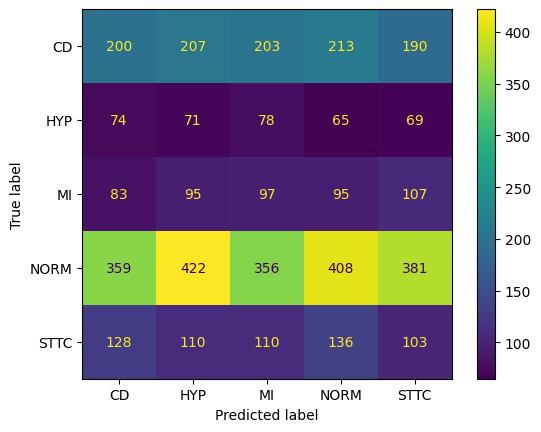

In [16]:
def random_classification(training_data):
    return [np.random.choice(classes) for _ in training_data]

predictions_train = random_classification(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = random_classification(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = random_classification(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

random_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=random_cm, display_labels=train_classes).plot();

Training accuracy: 0.20442448436460411
Validation accuracy: 0.1823020625415835
Test accuracy: 0.44174311926605503


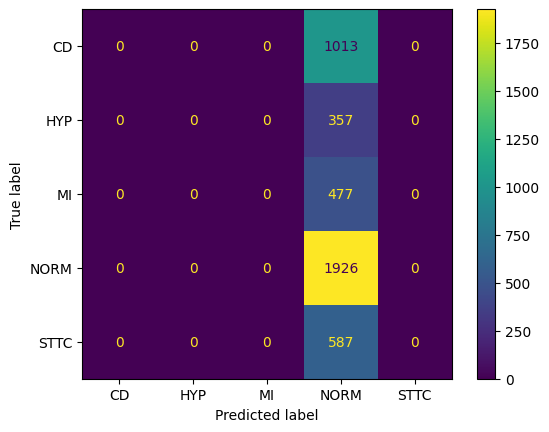

In [17]:
def always_classify_normal(training_data):
    return ['NORM'] * len(training_data)

predictions_train = always_classify_normal(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = always_classify_normal(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = always_classify_normal(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

normal_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=normal_cm, display_labels=train_classes).plot();

### Train Models

In [18]:
X_train_flattened = np.array([ekg.flatten() for ekg in X_train])
print(X_train_flattened.shape)

X_val_flattened = np.array([ekg.flatten() for ekg in X_val])
print(X_val_flattened.shape)

X_test_flattened = np.array([ekg.flatten() for ekg in X_test])
print(X_test_flattened.shape)

(6012, 12000)
(1503, 12000)
(4360, 12000)


**Decision Tree Classifier**

Training accuracy: 0.7904191616766467
Validation accuracy: 0.2774451097804391
Test accuracy: 0.2701834862385321


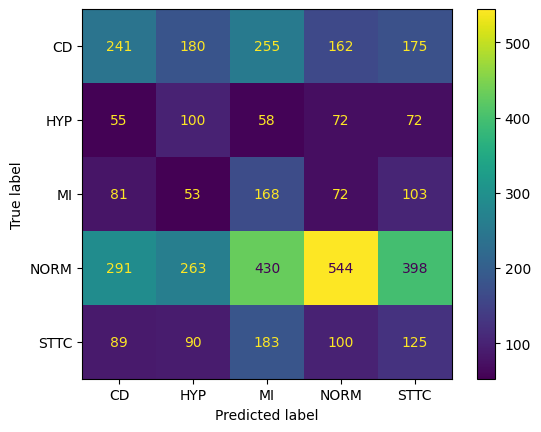

In [19]:
dt_model = DecisionTreeClassifier(max_depth = 12).fit(X_train_flattened, y_train) 

predictions_train = dt_model.predict(X_train_flattened)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = dt_model.predict(X_val_flattened)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = dt_model.predict(X_test_flattened)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

dt_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=train_classes).plot();

**Support Vector Machine (SVM)**

Training accuracy: 1.0
Validation accuracy: 0.2215568862275449
Test accuracy: 0.22293577981651377


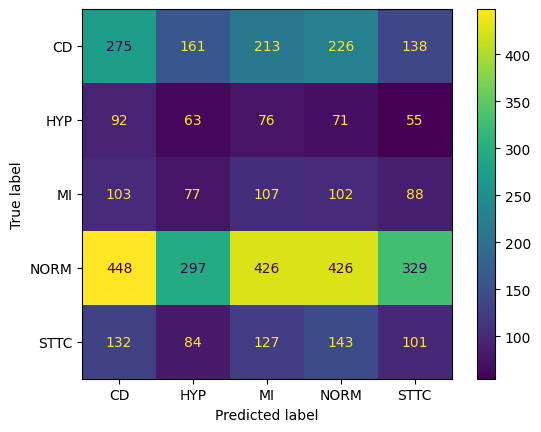

In [20]:
svm_model = SVC(kernel = 'linear', C = 1).fit(X_train_flattened, y_train) 

predictions_train = svm_model.predict(X_train_flattened)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

predictions_val = svm_model.predict(X_val_flattened)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

predictions_test = svm_model.predict(X_test_flattened)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

svc_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=train_classes).plot();

**Neural Network**

In [21]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [22]:
model = tf.keras.Sequential()
model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 12)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
# model.summary()

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
test_accuracy

Epoch 1/20
188/188 [==============================] - 7s 35ms/step - loss: 0.6169 - accuracy: 0.0983 - val_loss: 0.5421 - val_accuracy: 0.2794
Epoch 2/20
188/188 [==============================] - 7s 35ms/step - loss: 0.5539 - accuracy: 0.2633 - val_loss: 0.5280 - val_accuracy: 0.4225
Epoch 3/20
188/188 [==============================] - 7s 36ms/step - loss: 0.5387 - accuracy: 0.2979 - val_loss: 0.5072 - val_accuracy: 0.4025
Epoch 4/20
188/188 [==============================] - 7s 35ms/step - loss: 0.5284 - accuracy: 0.2971 - val_loss: 0.4919 - val_accuracy: 0.2954
Epoch 5/20
188/188 [==============================] - 6s 35ms/step - loss: 0.5250 - accuracy: 0.2801 - val_loss: 0.5082 - val_accuracy: 0.2828
Epoch 6/20
188/188 [==============================] - 7s 35ms/step - loss: 0.5104 - accuracy: 0.2843 - val_loss: 0.4722 - val_accuracy: 0.2821
Epoch 7/20
188/188 [==============================] - 7s 35ms/step - loss: 0.4895 - accuracy: 0.2811 - val_loss: 0.4506 - val_accuracy: 0.2615

0.4850917458534241